# Notebook to merge the VegFru dataset with Nutrify

* **Goal:** Merge the relevant classes + images from the VegFru dataset on Kaggle (https://www.kaggle.com/datasets/zhaoyj688/vegfru) to the Nutrify database.

* See this Google Sheet for classes relevant to Nutrify: https://docs.google.com/spreadsheets/d/1AbDDAuntzaI140wf5nAAgTbXe8thKJLr5E2ZbTlurbg/edit#gid=0 


In [2]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

import torch

from tqdm.auto import tqdm

from utils.misc import sort_dict_by_values

from zero_shot_classification import open_clip_compute_image_features_of_list, open_clip_compute_text_features, open_clip_zero_shot_classification, open_clip_get_image_and_text_similarity_dicts


/home/daniel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/daniel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowIlEET_S2_S2_b
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Get original labels to label new data from
# Get config
from configs.default_config import config

args = config

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

notes = f"merge vegfru dataset with Nutrify"

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['auto_label_new_images'],
                 notes=notes)

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

len(annotations.label.unique())

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


wandb: Currently logged in as: mrdbourke. Use `wandb login --relogin` to force relogin


[INFO] Labels directory: ./artifacts/food_vision_labels:v41
[INFO] Labels path: artifacts/food_vision_labels:v41/annotations.csv
[INFO] Working with: 247 classes


247

In [4]:
class_dict

{0: 'almond_butter',
 1: 'almonds',
 2: 'apple_green',
 3: 'apple_red',
 4: 'apricot',
 5: 'asparagus',
 6: 'avocado',
 7: 'bacon',
 8: 'bacon_and_egg_burger',
 9: 'bagel',
 10: 'baklava',
 11: 'banana',
 12: 'banana_bread',
 13: 'barbecue_sauce',
 14: 'basil',
 15: 'beans',
 16: 'beef_curry',
 17: 'beef_diced',
 18: 'beef_kebab',
 19: 'beef_mince',
 20: 'beef_patty',
 21: 'beef_roast',
 22: 'beef_stir_fry',
 23: 'beer',
 24: 'beetroot',
 25: 'biltong',
 26: 'blackberries',
 27: 'blueberries',
 28: 'bok_choy',
 29: 'bread',
 30: 'bread_naan',
 31: 'broccoli',
 32: 'broccolini',
 33: 'brownie',
 34: 'brussel_sprouts',
 35: 'burrito',
 36: 'butter',
 37: 'cabbage_green',
 38: 'cabbage_red',
 39: 'calamari',
 40: 'candy',
 41: 'capsicum_green',
 42: 'capsicum_orange',
 43: 'capsicum_red',
 44: 'capsicum_yellow',
 45: 'carrot',
 46: 'cashews',
 47: 'cauliflower',
 48: 'celery',
 49: 'cheese',
 50: 'cheeseburger',
 51: 'cherries',
 52: 'chicken_breast',
 53: 'chicken_thighs',
 54: 'chicken_

## Import VegFru class names

Source: https://docs.google.com/spreadsheets/d/1AbDDAuntzaI140wf5nAAgTbXe8thKJLr5E2ZbTlurbg/edit#gid=0

In [5]:
vegfru = pd.read_csv("nutrify-vegfru-dataset-class-crossover.csv")
print(f"Num rows: {len(vegfru)}")
vegfru.head()

Num rows: 293


class_name  in_nutrify nutrify_class_name category notes  \
0           almond         1.0            almonds    fruit   NaN   
1      green_apple         1.0        apple_green    fruit   NaN   
2            apple         1.0          apple_red    fruit   NaN   
3          apricot         1.0            apricot    fruit   NaN   
4  globe_artichoke         1.0          artichoke    fruit   NaN   

   Link to vegfru dataset -- https://www.kaggle.com/datasets/zhaoyj688/vegfru   
0                                                NaN                            
1                                                NaN                            
2                                                NaN                            
3                                                NaN                            
4                                                NaN

In [6]:
# Drop rows if the nutrify_class_name is nan
vegfru = vegfru.dropna(subset=['nutrify_class_name'])
print(f"Num rows: {len(vegfru)}")

Num rows: 107


In [7]:
# Get the unique class names
vegfru_nutrify_unique_class_names = vegfru.nutrify_class_name.unique()

# Compare the unique class names to the class names in the annotations
# nutrify_class_names_not_in_vegfru = [class_name for class_name in annotations.label.unique() if class_name not in vegfru_nutrify_unique_class_names]
# nutrify_class_names_in_vegfru = [class_name for class_name in annotations.label.unique() if class_name in vegfru_nutrify_unique_class_names]
vegfru_class_names_not_in_nutrify = sorted([class_name for class_name in vegfru_nutrify_unique_class_names if class_name not in class_names])
vegfru_class_names_not_in_nutrify

['artichoke',
 'bean_sprouts',
 'cherry_tomato',
 'chicory',
 'choko',
 'choy_sum',
 'cos_lettuce',
 'enoki_mushroom',
 'iceberg_lettuce',
 'mangosteen',
 'sweet_potato']

In [8]:
filter_list = ["cherry_tomato", "iceberg_lettuce", "sweet_potato", "enoki_mushroom", "cos_lettuce"]

# Remove the classes in the filter list
vegfru_class_names_not_in_nutrify = [class_name for class_name in vegfru_class_names_not_in_nutrify if class_name not in filter_list]
vegfru_class_names_not_in_nutrify

['artichoke', 'bean_sprouts', 'chicory', 'choko', 'choy_sum', 'mangosteen']

In [9]:
# !unzip all_vegfru_images.zip

In [10]:
# How many images are in all_vegfru_images
target_dir = 'all_vegfru_images'
path = Path(target_dir)
image_paths = sorted(list(path.glob('*/*.jp*g')))
print(f"There are {len(image_paths)} images in {target_dir}")

There are 160731 images in all_vegfru_images


In [11]:
vegfru_class_names_to_move_to_nutrify = vegfru.class_name.to_list()
vegfru_nutrify_unique_class_names  = vegfru.nutrify_class_name.to_list()
len(vegfru_class_names_to_move_to_nutrify), len(vegfru_nutrify_unique_class_names)

(107, 107)

In [12]:
# Get rows of vegfru where the nutrify_class_name is in vegfru_class_names_not_in_nutrify
vegfru_class_names_not_in_nutrify_df = vegfru[vegfru.nutrify_class_name.isin(vegfru_class_names_not_in_nutrify)]
vegfru_class_names_not_in_nutrify_df

class_name  in_nutrify nutrify_class_name   category notes  \
4          globe_artichoke         1.0          artichoke      fruit   NaN   
9       black_bean_sprouts         1.0       bean_sprouts  vegetable   NaN   
10       mung_bean_sprouts         1.0       bean_sprouts  vegetable   NaN   
11         soybean_sprouts         1.0       bean_sprouts        NaN   NaN   
24                 chicory         1.0            chicory  vegetable   NaN   
27                  chocho         1.0              choko      fruit   NaN   
28  flower_chinese_cabbage         1.0           choy_sum  vegetable   NaN   
63              mangosteen         1.0         mangosteen      fruit   NaN   

    Link to vegfru dataset -- https://www.kaggle.com/datasets/zhaoyj688/vegfru   
4                                                 NaN                            
9                                                 NaN                            
10                                                NaN                            
11                                                NaN                            
24                                                NaN                            
27                                                NaN                            
28                                                NaN                            
63                                                NaN

In [13]:
vegfru_class_names_to_move_to_nutrify = vegfru_class_names_not_in_nutrify_df.class_name.to_list()
vegfru_class_names_to_move_to_nutrify

['globe_artichoke',
 'black_bean_sprouts',
 'mung_bean_sprouts',
 'soybean_sprouts',
 'chicory',
 'chocho',
 'flower_chinese_cabbage',
 'mangosteen']

In [14]:
# How many images are in the folders of the vegfru_class_names_to_move_to_nutrify
vegfru_nutrify_images = []
for image_path in image_paths:
    if image_path.parent.name in vegfru_class_names_to_move_to_nutrify:
        vegfru_nutrify_images.append(image_path)
print(f"There are {len(vegfru_nutrify_images)} images in {target_dir} that are in the vegfru_class_names_to_move_to_nutrify")

There are 3840 images in all_vegfru_images that are in the vegfru_class_names_to_move_to_nutrify


In [15]:
# Get a map of the vegfru class names to the nutrify class names
vegfru_to_nutrify_dict = vegfru[["class_name", "nutrify_class_name"]].drop_duplicates().set_index("class_name").to_dict()["nutrify_class_name"]
len(vegfru_to_nutrify_dict)

107

In [16]:
vegfru_to_nutrify_dict

{'almond': 'almonds',
 'green_apple': 'apple_green',
 'apple': 'apple_red',
 'apricot': 'apricot',
 'globe_artichoke': 'artichoke',
 'asparagus': 'asparagus',
 'avocado': 'avocado',
 'banana': 'banana',
 'basil': 'basil',
 'black_bean_sprouts': 'bean_sprouts',
 'mung_bean_sprouts': 'bean_sprouts',
 'soybean_sprouts': 'bean_sprouts',
 'beetroot': 'beetroot',
 'blueberry': 'blueberries',
 'pakchoi': 'bok_choy',
 'sprouting_broccoli': 'broccoli',
 'brussels_sprouts': 'brussel_sprouts',
 'red_cabbage': 'cabbage_red',
 'carrot': 'carrot',
 'cashew_nut': 'cashews',
 'broccoli': 'cauliflower',
 'celery': 'celery',
 'cherry': 'cherries',
 'cherry_tomato': 'cherry_tomato',
 'chicory': 'chicory',
 'pepper': 'chilli',
 'chive': 'chives',
 'chocho': 'choko',
 'flower_chinese_cabbage': 'choy_sum',
 'coconut': 'coconut',
 'coriander': 'coriander',
 'corn': 'corn',
 nan: 'cos_lettuce',
 'cucumber': 'cucumber',
 'soybean': 'edamame',
 'eggplant': 'eggplant',
 'endive': 'endive',
 'enoki_mushroom': 'en

In [17]:
# Make a directory for storing nutrify-vegfru images
# !mkdir all_nutrify_vegfru

# Make a directory for each class inside all_nutrify_vegfru
import os
nutrify_vegfru_dir = "all_nutrify_vegfru"
for class_name in vegfru_to_nutrify_dict.values():
    os.makedirs(f"{nutrify_vegfru_dir}/{class_name}", exist_ok=True)
    # !mkdir all_nutrify_vegfru/{class_name}

In [18]:
# Copy the images to the correct directory
import shutil
from tqdm.auto import tqdm
for image_path in tqdm(vegfru_nutrify_images):
    if image_path.parent.name in vegfru_class_names_to_move_to_nutrify:
        # Get the nutrify class name
        nutrify_class_name = vegfru_to_nutrify_dict[image_path.parent.name]
        # Copy the image to the nutrify class name directory
        print(f"Copying {image_path} to {nutrify_vegfru_dir}/{nutrify_class_name}/{image_path.name}")
        shutil.copy(image_path, f"{nutrify_vegfru_dir}/{nutrify_class_name}/{image_path.name}")

  0%|          | 0/3840 [00:00<?, ?it/s]

Copying all_vegfru_images/black_bean_sprouts/v_04_01_0001.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0001.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0002.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0002.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0003.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0003.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0004.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0004.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0005.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0005.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0006.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0006.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0007.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0007.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0008.jpg to all_nutrify_vegfru/bean_sprouts/v_04_01_0008.jpg
Copying all_vegfru_images/black_bean_sprouts/v_04_01_0009.jpg to all_nutrify_vegfru/bean

In [19]:
# Get all the paths
nutrify_vegfru_paths = sorted(list(Path(nutrify_vegfru_dir).glob('*/*.jp*g')))
print(len(nutrify_vegfru_paths))

import uuid

def is_valid_uuid(string):
    try:
        uuid.UUID(string)
        return True
    except ValueError:
        return False

# Loop through all_paths, if the path is a UUID, pass, if not, rename the file to a UUID
for path in tqdm(nutrify_vegfru_paths):
    if not is_valid_uuid(path.stem):
        print(f"[INFO] {path} isn't valud UUID, renaming to UUID...")
        new_name = f"{uuid.uuid4()}.jpeg"
        new_path_name = path.parent / new_name
        path.rename(new_path_name)
        print(f"[INFO] Renamed {path} to {new_path_name}")

# Get all the paths again
nutrify_vegfru_paths = sorted(list(Path(nutrify_vegfru_dir).glob('*/*.jp*g')))


74654


  0%|          | 0/74654 [00:00<?, ?it/s]

[INFO] all_nutrify_vegfru/artichoke/v_12_05_0001.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0001.jpg to all_nutrify_vegfru/artichoke/a24c75dd-1add-429b-9c5a-99c7a9b4e518.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0002.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0002.jpg to all_nutrify_vegfru/artichoke/1f92f28a-4215-4ed8-b892-ba9b87ef7661.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0003.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0003.jpg to all_nutrify_vegfru/artichoke/661e278e-7e12-442d-9ba4-9a38f3be8711.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0004.jpg isn't valud UUID, renaming to UUID...
[INFO] Renamed all_nutrify_vegfru/artichoke/v_12_05_0004.jpg to all_nutrify_vegfru/artichoke/d1705812-da97-4cff-81ec-267512fc79f7.jpeg
[INFO] all_nutrify_vegfru/artichoke/v_12_05_0005.jpg isn't valud UUID, renaming to UUID...
[INFO

In [ ]:
# Show some random images from the dataset
import random
import matplotlib.pyplot as plt

# Get image_paths for the classes we want to filter
image_paths_to_filter = []
for image_path in nutrify_vegfru_paths:
    if image_path.parent.name in vegfru_class_names_not_in_nutrify:
        image_paths_to_filter.append(image_path)

print(f"There are {len(image_paths_to_filter)} images in {nutrify_vegfru_dir} that are in the classes_to_filter_nutrify_names")

def show_random_images(image_paths, num_images=10):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images*5, 5))
    for i in range(num_images):
        image_path = random.choice(image_paths)
        image = plt.imread(image_path)
        ax[i].imshow(image)
        ax[i].set_title(image_path.parent.name)
        ax[i].axis("off")
    plt.show()

show_random_images(image_paths_to_filter, num_images=10)

## Filter images requiring filtering into their own directories

1. Go through `image_paths_to_filter`
2. Use OpenCLIP zero-shot to see which class they should belong to (this won't be perfect but it'll be okay)
3. Move the image to the correct directory

In [62]:
lettuce_features = open_clip_compute_text_features(lettuce_options)
potato_features = open_clip_compute_text_features(potato_options)
grape_features = open_clip_compute_text_features(grape_options)
onion_features = open_clip_compute_text_features(onion_options)

# Loop through images and compute the image features
image_paths_to_filter_features = []
for image_path in tqdm(image_paths_to_filter):
    image_features = open_clip_compute_image_features_of_list([image_path])
    image_paths_to_filter_features = image_features

  0%|          | 0/4751 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

In [72]:
image_paths_to_filter_features_dicts = [item[0] for item in list(image_paths_to_filter_features.values())]
image_paths_to_filter_features_dicts[:3]

[{'image_path': PosixPath('all_nutrify_vegfru/grapes_white/000ef72c-e587-420d-a241-b0770f2523ae.jpeg'),
  'image_features': tensor([[ 0.0022, -0.0472, -0.0466,  ..., -0.0015,  0.0087,  0.0388]],
         device='cuda:0', dtype=torch.float16)},
 {'image_path': PosixPath('all_nutrify_vegfru/grapes_white/0023b83d-a3c5-400e-a51d-4b3c84d2f53c.jpeg'),
  'image_features': tensor([[-0.0352, -0.0064, -0.0354,  ...,  0.0352,  0.0103,  0.0195]],
         device='cuda:0', dtype=torch.float16)},
 {'image_path': PosixPath('all_nutrify_vegfru/grapes_white/0033190c-4689-4cc2-a4d6-fc9cf1bfeda0.jpeg'),
  'image_features': tensor([[-0.0110, -0.0136, -0.0339,  ..., -0.0087, -0.0051,  0.0061]],
         device='cuda:0', dtype=torch.float16)}]

In [79]:
# Get lettuce feature dicts
lettuce_feature_dicts = [item for item in image_paths_to_filter_features_dicts if item["image_path"].parent.name == "iceberg_lettuce"]
# lettuce_paths = [image_path for image_path in image_paths_to_filter if image_path.parent.name == "iceberg_lettuce"]

# Get potato feature dicts
potato_feature_dicts = [item for item in image_paths_to_filter_features_dicts if item["image_path"].parent.name == "potato_brown"]
# potato_paths = [image_path for image_path in image_paths_to_filter if image_path.parent.name == "potato_brown"]

# Get grape feature dicts
grape_feature_dicts = [item for item in image_paths_to_filter_features_dicts if item["image_path"].parent.name == "grapes_white"]
# grape_paths = [image_path for image_path in image_paths_to_filter if image_path.parent.name == "grapes_white"]

# Get onion feature dicts
onion_feature_dicts = [item for item in image_paths_to_filter_features_dicts if item["image_path"].parent.name == "onion_brown"]
# onion_paths = [image_path for image_path in image_paths_to_filter if image_path.parent.name == "onion_brown"]

# Find the lengths of each
print(f"There are {len(lettuce_feature_dicts)} lettuce images")
print(f"There are {len(potato_feature_dicts)} potato images")
print(f"There are {len(grape_feature_dicts)} grape images")
print(f"There are {len(onion_feature_dicts)} onion images")

There are 538 lettuce images
There are 585 potato images
There are 2491 grape images
There are 1137 onion images


In [ ]:
lettuce_features = open_clip_compute_text_features(lettuce_options)
potato_features = open_clip_compute_text_features(potato_options)
grape_features = open_clip_compute_text_features(grape_options)
onion_features = open_clip_compute_text_features(onion_options)

In [82]:
# Get lettuce similarity dicts
lettuce_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(lettuce_feature_dicts, lettuce_options)

# Get potato similarity dicts
potato_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(potato_feature_dicts, potato_options)

# Get grape similarity dicts
grape_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(grape_feature_dicts, grape_options)

# Get onion similarity dicts
onion_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(onion_feature_dicts, onion_options)

Calculating image features and similarity dicts:   0%|          | 0/538 [00:00<?, ?it/s]

Calculating image features and similarity dicts:   0%|          | 0/585 [00:00<?, ?it/s]

Calculating image features and similarity dicts:   0%|          | 0/2491 [00:00<?, ?it/s]

Calculating image features and similarity dicts:   0%|          | 0/1137 [00:00<?, ?it/s]

In [83]:
# Create dataframes of the similarity dicts
lettuce_similarity_df = pd.DataFrame(lettuce_similarity_dicts)
potato_similarity_df = pd.DataFrame(potato_similarity_dicts)
onion_similarity_df = pd.DataFrame(onion_similarity_dicts)
grape_similarity_df = pd.DataFrame(grape_similarity_dicts)

In [84]:
lettuce_similarity_df.open_clip_top_1_class_name.value_counts()

cos_lettuce        331
oakleaf_lettuce    112
iceberg_lettuce     95
Name: open_clip_top_1_class_name, dtype: int64

In [85]:
onion_similarity_df.open_clip_top_1_class_name.value_counts()

onion_brown    460
onion_red      423
onion_white    254
Name: open_clip_top_1_class_name, dtype: int64

In [86]:
potato_similarity_df.open_clip_top_1_class_name.value_counts()

potato_brown    289
potato_white    199
potato_red       97
Name: open_clip_top_1_class_name, dtype: int64

In [87]:
grape_similarity_df.open_clip_top_1_class_name.value_counts()

grapes_white    1081
grapes_black     811
grapes_red       599
Name: open_clip_top_1_class_name, dtype: int64

In [88]:
lettuce_similarity_df.head()

image_path  \
0  all_nutrify_vegfru/iceberg_lettuce/0068e483-f9...   
1  all_nutrify_vegfru/iceberg_lettuce/0090ea91-1e...   
2  all_nutrify_vegfru/iceberg_lettuce/01242397-21...   
3  all_nutrify_vegfru/iceberg_lettuce/01bc9169-6e...   
4  all_nutrify_vegfru/iceberg_lettuce/0217e9c4-5a...   

                    open_clip_sorted_similarity_dict  \
0  {'cos_lettuce': 0.8617330193519592, 'iceberg_l...   
1  {'cos_lettuce': 0.6493512392044067, 'oakleaf_l...   
2  {'iceberg_lettuce': 0.9101762175559998, 'cos_l...   
3  {'oakleaf_lettuce': 0.41463157534599304, 'cos_...   
4  {'cos_lettuce': 0.9311216473579407, 'iceberg_l...   

  open_clip_top_1_class_name  open_clip_top_1_similarity_score  
0                cos_lettuce                          0.861733  
1                cos_lettuce                          0.649351  
2            iceberg_lettuce                          0.910176  
3            oakleaf_lettuce                          0.414632  
4                cos_lettuce                          0.931122

## Move images to their respective folders

* Make folders for the new class splits
* Move the images from the original dataset into the new class folders

In [93]:
new_folders_to_create = lettuce_options + onion_options + potato_options + grape_options

# Create new folders for each class
for new_folder in new_folders_to_create:
    new_folder_path = Path(nutrify_vegfru_dir, new_folder)
    print(new_folder_path)
    if not new_folder_path.exists():
        os.makedirs(new_folder_path)

all_nutrify_vegfru/cos_lettuce
all_nutrify_vegfru/iceberg_lettuce
all_nutrify_vegfru/oakleaf_lettuce
all_nutrify_vegfru/onion_red
all_nutrify_vegfru/onion_white
all_nutrify_vegfru/onion_brown
all_nutrify_vegfru/potato_brown
all_nutrify_vegfru/potato_red
all_nutrify_vegfru/potato_white
all_nutrify_vegfru/grapes_black
all_nutrify_vegfru/grapes_white
all_nutrify_vegfru/grapes_red


In [95]:
# Combine all of the similarity dicts
all_similarity_dicts = lettuce_similarity_dicts + potato_similarity_dicts + onion_similarity_dicts + grape_similarity_dicts

len(all_similarity_dicts)

4751

In [97]:
# Loop through the similarity dict and move each image to the appropriate folder
for similarity_dict in tqdm(all_similarity_dicts):
    image_path = similarity_dict["image_path"]
    image_class = similarity_dict["open_clip_top_1_class_name"]
    new_image_path = Path(nutrify_vegfru_dir, image_class, image_path.name)
    print(f"Moving {image_path} to {new_image_path}")
    shutil.move(image_path, new_image_path)

  0%|          | 0/4751 [00:00<?, ?it/s]

Moving all_nutrify_vegfru/iceberg_lettuce/0068e483-f90c-45e7-a742-a2685d2a76f1.jpeg to all_nutrify_vegfru/cos_lettuce/0068e483-f90c-45e7-a742-a2685d2a76f1.jpeg
Moving all_nutrify_vegfru/iceberg_lettuce/0090ea91-1e32-4cec-954d-f97e76b317be.jpeg to all_nutrify_vegfru/cos_lettuce/0090ea91-1e32-4cec-954d-f97e76b317be.jpeg
Moving all_nutrify_vegfru/iceberg_lettuce/01242397-21c8-4292-ba66-ec8750d80a95.jpeg to all_nutrify_vegfru/iceberg_lettuce/01242397-21c8-4292-ba66-ec8750d80a95.jpeg
Moving all_nutrify_vegfru/iceberg_lettuce/01bc9169-6e52-4630-a1af-a2a3cd82c0fb.jpeg to all_nutrify_vegfru/oakleaf_lettuce/01bc9169-6e52-4630-a1af-a2a3cd82c0fb.jpeg
Moving all_nutrify_vegfru/iceberg_lettuce/0217e9c4-5a19-4f37-af67-24e1a07bf3f6.jpeg to all_nutrify_vegfru/cos_lettuce/0217e9c4-5a19-4f37-af67-24e1a07bf3f6.jpeg
Moving all_nutrify_vegfru/iceberg_lettuce/021e2c95-e9a0-4724-b576-da7297958522.jpeg to all_nutrify_vegfru/cos_lettuce/021e2c95-e9a0-4724-b576-da7297958522.jpeg
Moving all_nutrify_vegfru/iceber

In [99]:
# Get all the image paths from nutrify_vegfru_dir
image_paths = list(Path(nutrify_vegfru_dir).rglob("*/*.jp*g"))
len(image_paths)


69501

In [101]:
# Get a breakdown of the number of images in each class
image_paths_and_names = []
for image_path in image_paths:
    image_paths_and_names.append({"image_path": image_path, "class_name": image_path.parent.name})
    # print(image_path.parent.name)

In [104]:
image_path_and_name_df = pd.DataFrame(image_paths_and_names)
image_path_and_name_df.class_name.value_counts()

eggplant           1807
grapes_red         1633
papaya             1614
mango              1474
garlic             1420
                   ... 
parsnips            226
potato_white        199
oakleaf_lettuce     112
potato_red           97
iceberg_lettuce      95
Name: class_name, Length: 98, dtype: int64

In [107]:
images_to_move_to_nutrify_features = open_clip_compute_image_features_of_list(image_paths)

Computing OpenCLIP image features:   0%|          | 0/69501 [00:00<?, ?it/s]

/home/daniel/.local/lib/python3.8/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## See whether the images contain people or not 

* Use CLIP to decide whether the image has a person or not (we're only interested in images without people)

In [163]:
human_or_not = ["human", "no_human", "food", "other", "human_face", "person"]

human_or_not_similarity_dicts = open_clip_get_image_and_text_similarity_dicts(images_to_move_to_nutrify_features, human_or_not)

Calculating image features and similarity dicts:   0%|          | 0/69501 [00:00<?, ?it/s]

In [164]:
human_or_not_df = pd.DataFrame(human_or_not_similarity_dicts)

human_or_not_df.open_clip_top_1_class_name.value_counts()

food          66974
other          1468
human           615
person          387
human_face       36
no_human         21
Name: open_clip_top_1_class_name, dtype: int64

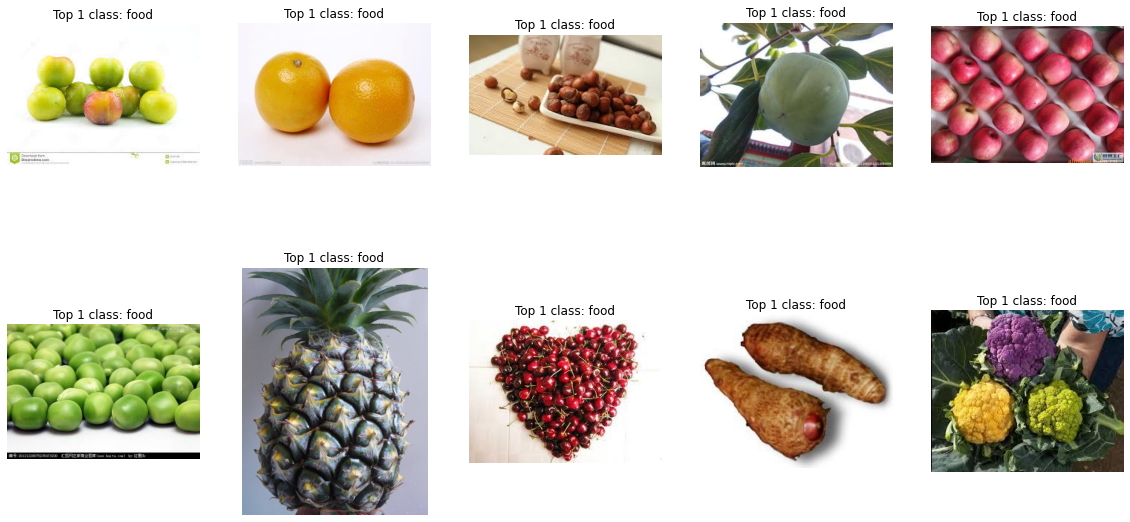

In [182]:
# Show the images which contain a person
from PIL import Image
food_only = human_or_not_df[human_or_not_df.open_clip_top_1_class_name == "food"]
may_contain_person = human_or_not_df[human_or_not_df.open_clip_top_1_class_name != "food"]

# Plot 10 random images which contain a person
# Plot 10 random images with their top 1 class_name
import matplotlib.pyplot as plt

def plot_10_random_images_from_df(df, image_path_col="image_path", title_col=None):
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))
    for i, row in enumerate(df.sample(10).iterrows()):
        row = row[1]
        # print(i)
        ax[i // 5, i % 5].imshow(plt.imread(row[image_path_col]))
        ax[i // 5, i % 5].set_title(f"Top 1 class: {row[title_col]}")
        ax[i // 5, i % 5].axis(False)


plot_10_random_images_from_df(df=food_only, image_path_col="image_path", title_col="open_clip_top_1_class_name")

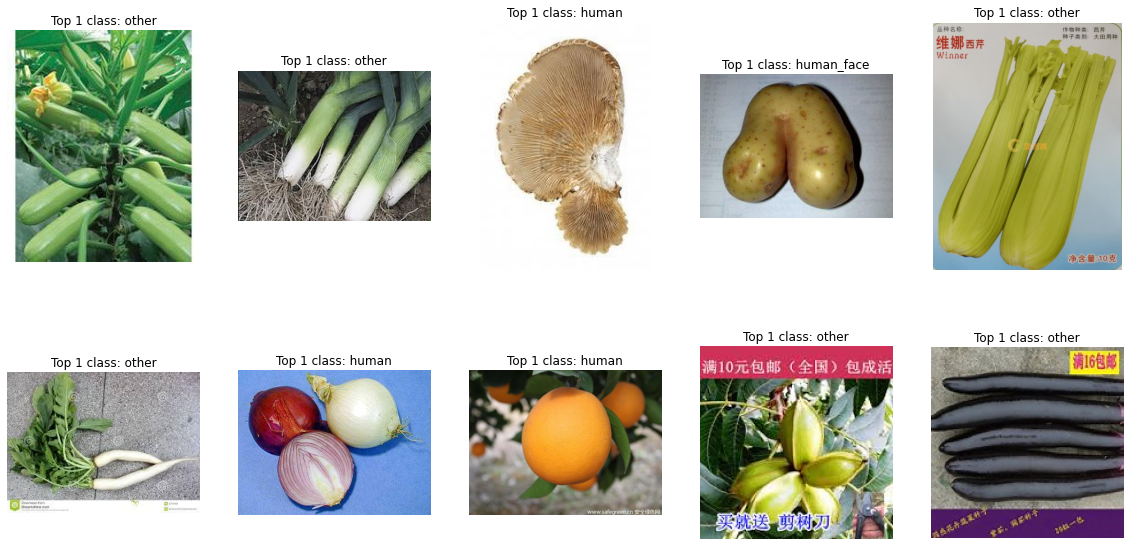

In [188]:
plot_10_random_images_from_df(df=may_contain_person, image_path_col="image_path", title_col="open_clip_top_1_class_name")

In [189]:
# Get the image paths which don't contain a person
no_person_image_paths = food_only.image_path.to_list()
len(no_person_image_paths)

66974

In [191]:
# Delete images which aren't food
images_removed = 0
for image_path in tqdm(may_contain_person.image_path.to_list()):
    print(f"Deleting {image_path}")
    images_removed += 1
    os.remove(image_path)

  0%|          | 0/2527 [00:00<?, ?it/s]

Deleting all_nutrify_vegfru/watermelon/6c505e61-af28-4f14-b2bd-b4c851a63b74.jpeg
Deleting all_nutrify_vegfru/watermelon/8599c407-510c-4f76-b3df-5a54c4f5296f.jpeg
Deleting all_nutrify_vegfru/watermelon/db30f1e4-5c7a-4402-a8c0-8ced365d35f5.jpeg
Deleting all_nutrify_vegfru/watermelon/99d9682b-111f-40fe-a1bd-40aa2d66e045.jpeg
Deleting all_nutrify_vegfru/watermelon/f6dbeb8e-9eb3-40ab-bba7-6a9333ec6286.jpeg
Deleting all_nutrify_vegfru/watermelon/8249862e-3c0d-4aee-bbef-a4f6c6de14d4.jpeg
Deleting all_nutrify_vegfru/watermelon/b29c5dcd-84c6-491d-9648-3455f2674b41.jpeg
Deleting all_nutrify_vegfru/watermelon/40dfdae7-d817-4b9a-a57c-d9bace97af54.jpeg
Deleting all_nutrify_vegfru/watermelon/3b47d574-77a7-4a1b-a1e2-978a492a84cc.jpeg
Deleting all_nutrify_vegfru/watermelon/9a083249-f916-4994-b70e-2a30b396c408.jpeg
Deleting all_nutrify_vegfru/watermelon/5a528d9b-427c-4ec9-a689-bd4c0027a343.jpeg
Deleting all_nutrify_vegfru/watermelon/905ecc27-d5f5-4678-a6c3-c1790d12d3f5.jpeg
Deleting all_nutrify_vegfru/

In [192]:
# Get all the paths to the images in nutrify_vegfru_dir
updated_image_paths = list(Path(nutrify_vegfru_dir).rglob("*/*.jp*g"))
len(updated_image_paths)

66974

In [ ]:
# Steps
# Remove macOSX files from zip ✅
# Sort all VegFru class names into Nutrify classes (image folders for each) ✅
# Rename the images to have UUIDs ✅
# Filter the images into separate classes for "lettuce", "potato", "onion", "radish" etc ✅
    # - **lettuce** → cos_lettuce, iceberg_lettuce, oakleaf_lettuce
    # - **grapes** → grapes_black, grapes_red, grapes_white
    # - **onion** → onion_red, onion_brown, onion_white
    # - **potato** → potato_brown, potato_red, potato_white

# Filter the images for people/not people (use CLIP) ✅
# Move the images without people to Nutrify folers ✅

# Next: 
# Create annotations for the new images - add "image_source" = vegfru_dataset column to annotations
# Upload the images to Google Storage
# Add the images to the Nutrify dataset on Google Storage
# Track and update the labels in the Nutrify dataset on Google Storage
# Clean the Google Storage dataset for duplicates
# Train a model with new images 

In [199]:
food_only

image_path  \
0      all_nutrify_vegfru/watermelon/2b0008f0-acee-4e...   
1      all_nutrify_vegfru/watermelon/65b3f959-9323-46...   
2      all_nutrify_vegfru/watermelon/afabe442-7fb7-4d...   
3      all_nutrify_vegfru/watermelon/4fa0e3b8-c30f-45...   
4      all_nutrify_vegfru/watermelon/0ac3a9d3-605e-4e...   
...                                                  ...   
69496  all_nutrify_vegfru/onion_brown/dcfb12aa-529a-4...   
69497  all_nutrify_vegfru/onion_brown/56092377-8538-4...   
69498  all_nutrify_vegfru/onion_brown/2abe0c8a-d934-4...   
69499  all_nutrify_vegfru/onion_brown/dc0cccea-9c94-4...   
69500  all_nutrify_vegfru/onion_brown/9e216cc8-65d9-4...   

                        open_clip_sorted_similarity_dict  \
0      {'food': 0.9784009456634521, 'other': 0.012608...   
1      {'food': 0.8023183345794678, 'other': 0.160473...   
2      {'food': 0.962847888469696, 'other': 0.0248695...   
3      {'food': 0.9691352844238281, 'other': 0.028811...   
4      {'food': 0.8711335062980652, 'other': 0.118819...   
...                                                  ...   
69496  {'food': 0.9029319286346436, 'person': 0.03875...   
69497  {'food': 0.6772257089614868, 'human': 0.257045...   
69498  {'food': 0.5530550479888916, 'person': 0.26124...   
69499  {'food': 0.9410713315010071, 'person': 0.04007...   
69500  {'food': 0.9491837620735168, 'human': 0.034037...   

      open_clip_top_1_class_name  open_clip_top_1_similarity_score  
0                           food                          0.978401  
1                           food                          0.802318  
2                           food                          0.962848  
3                           food                          0.969135  
4                           food                          0.871134  
...                          ...                               ...  
69496                       food                          0.902932  
69497                       food                          0.677226  
69498                       food                          0.553055  
69499                       food                          0.941071  
69500                       food                          0.949184  

[66974 rows x 4 columns]

In [218]:
# Find the classes which aren't in Nutrify from the updated VegFru dataset
food_only_paths = food_only.image_path.to_list()
vegfru_class_names_updated = [image_path.parent.name for image_path in food_only_paths]
vegfru_class_names_updated = list(set(vegfru_class_names_updated))
vegfru_class_names_updated

['chives',
 'broccoli',
 'olives',
 'strawberries',
 'coriander',
 'walnuts',
 'iceberg_lettuce',
 'orange',
 'mushroom_oyster',
 'grapes_red',
 'shallots',
 'spinach',
 'peach',
 'enoki_mushroom',
 'radish_white',
 'longan',
 'leek',
 'asparagus',
 'cherry_tomato',
 'mango',
 'garlic',
 'zucchini',
 'peas',
 'fennel',
 'lime',
 'cauliflower',
 'apple_green',
 'onion_brown',
 'guava',
 'grapefruit',
 'avocado',
 'banana',
 'watermelon',
 'carrot',
 'sweet_potato',
 'radish_red',
 'cos_lettuce',
 'pineapple',
 'nectarine',
 'blueberries',
 'parsnips',
 'raspberries',
 'apricot',
 'swiss_chard',
 'onion_red',
 'figs',
 'mandarin',
 'grapes_white',
 'onion_white',
 'rhubarb',
 'basil',
 'onion_green',
 'endive',
 'lychee',
 'potato_white',
 'ginger',
 'mint',
 'potato_brown',
 'kiwi_fruit',
 'bok_choy',
 'pear_nashi',
 'pomegranate',
 'passionfruit',
 'pumpkin',
 'plum',
 'pecans',
 'eggplant',
 'parsley',
 'oakleaf_lettuce',
 'cashews',
 'coconut',
 'grapes_black',
 'papaya',
 'almonds',

In [219]:
# Find the classes that are in vegfru_class_names_updated but not in class_names
vegfru_class_names_not_in_nutrify_updated = list(set(vegfru_class_names_updated)- set(class_names))
len(vegfru_class_names_not_in_nutrify_updated)

26

In [220]:
class_dict_updated = class_dict.copy()
class_names_updated = class_names.copy()
reverse_class_dict_updated = reverse_class_dict.copy()

print(f"Number of classes in Nutrify: {len(class_names)}")

Number of classes in Nutrify: 209


In [221]:
# Add new classes to class_dict
for food_type in vegfru_class_names_not_in_nutrify_updated:
    class_dict_updated[len(class_dict_updated)] = food_type
    class_names_updated.append(food_type)
    reverse_class_dict_updated[food_type] = len(class_dict_updated)-1

In [222]:
print(f"Number of classes in Nutrify: {len(class_names_updated)}")

Number of classes in Nutrify: 235


In [223]:
len(set(class_names_updated))

235

In [225]:
from utils.misc import get_now_time

# Create a list of dictionaries and fill out the columns of the annotations
columns = config.annotations_columns_to_export

food_image_dict_list = []

image_source = "vegfru_dataset"
label_source = "vegfru_dataset_with_manual_filtering"
label_last_updated_at = get_now_time()

for image_path in updated_image_paths:
    food_image_dict = {}
    food_image_dict['filename'] = image_path
    food_image_dict['image_name'] = image_path.name
    food_image_dict['class_name'] = image_path.parent.name
    food_image_dict['label'] = reverse_class_dict_updated[image_path.parent.name]
    # food_image_dict['split'] = 'train'
    # Label 20% of the images as test
    if np.random.random() < 0.2:
        food_image_dict['split'] = 'test'
    else:
        food_image_dict['split'] = 'train'
    food_image_dict['clear_or_confusing'] = None
    food_image_dict['whole_food_or_dish'] = None
    food_image_dict['one_food_or_multiple'] = None
    food_image_dict['label_last_updated_at'] = label_last_updated_at
    food_image_dict['label_source'] = label_source
    food_image_dict['image_source'] = image_source

    food_image_dict_list.append(food_image_dict)

# Create a dataframe from the list of dictionaries
import pandas as pd
new_annotations = pd.DataFrame(food_image_dict_list)
new_annotations.head()

filename  \
0  all_nutrify_vegfru/watermelon/2b0008f0-acee-4e...   
1  all_nutrify_vegfru/watermelon/65b3f959-9323-46...   
2  all_nutrify_vegfru/watermelon/afabe442-7fb7-4d...   
3  all_nutrify_vegfru/watermelon/4fa0e3b8-c30f-45...   
4  all_nutrify_vegfru/watermelon/0ac3a9d3-605e-4e...   

                                  image_name  class_name  label  split  \
0  2b0008f0-acee-4ecc-890d-c1ca4ed354a4.jpeg  watermelon    204  train   
1  65b3f959-9323-465c-96fb-6b30d4e34df6.jpeg  watermelon    204   test   
2  afabe442-7fb7-4d3a-ac07-a763723dccde.jpeg  watermelon    204  train   
3  4fa0e3b8-c30f-45a8-b1d5-0928f6431381.jpeg  watermelon    204  train   
4  0ac3a9d3-605e-4e1c-8ae3-4daa54bc50b0.jpeg  watermelon    204  train   

  clear_or_confusing whole_food_or_dish one_food_or_multiple  \
0               None               None                 None   
1               None               None                 None   
2               None               None                 None   
3               None               None                 None   
4               None               None                 None   

  label_last_updated_at                          label_source    image_source  
0   2023-02-27_14-38-31  vegfru_dataset_with_manual_filtering  vegfru_dataset  
1   2023-02-27_14-38-31  vegfru_dataset_with_manual_filtering  vegfru_dataset  
2   2023-02-27_14-38-31  vegfru_dataset_with_manual_filtering  vegfru_dataset  
3   2023-02-27_14-38-31  vegfru_dataset_with_manual_filtering  vegfru_dataset  
4   2023-02-27_14-38-31  vegfru_dataset_with_manual_filtering  vegfru_dataset

In [226]:
# Get the split of the new annotations
new_annotations.split.value_counts()

train    53436
test     13538
Name: split, dtype: int64

In [227]:
# Get the number of images in each class
new_annotations.class_name.value_counts()

eggplant           1636
grapes_red         1612
papaya             1593
mango              1442
garlic             1409
                   ... 
potato_white        195
mushroom_oyster     166
oakleaf_lettuce     112
iceberg_lettuce      93
potato_red           93
Name: class_name, Length: 98, dtype: int64

In [229]:
# Get the rows with labels over 208
new_annotations[new_annotations.label > 208].class_name.value_counts()

pecans             1183
cherry_tomato      1183
nectarine          1023
walnuts            1016
longan              940
persimmon           937
pistachio           814
edamame             800
macadamia           762
basil               670
swiss_chard         636
mint                575
okra                495
pear_nashi          482
radish_red          469
hazelnuts           449
cabbage_red         403
endive              399
radish_white        380
honeydew_melon      373
cos_lettuce         331
chives              237
watercress          202
mushroom_oyster     166
oakleaf_lettuce     112
potato_red           93
Name: class_name, dtype: int64

In [231]:
original_annotations = annotations.copy()

In [232]:
len(original_annotations), len(new_annotations)

(41765, 66974)

In [233]:
# Append the new_annotations to the original_annotations
updated_annotations = pd.concat([original_annotations, new_annotations], ignore_index=True)

# updated_annotations = original_annotations.(new_annotations, ignore_index=True)
len(updated_annotations)

108739

In [234]:
# How many unique class_names are in original_annotations?
len(original_annotations['class_name'].unique())

209

In [235]:
# How many unique class_names are in updated_annotations?
len(updated_annotations['class_name'].unique())

235

In [237]:
# Check the difference in lengths between the original_annotations and updated_annotations
num_differences = len(updated_annotations) - len(original_annotations)
print(num_differences)

66974


In [239]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 66974 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 20807727 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-02-27_14-42-36_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


## Upload all photos to Google Cloud Storage

In [240]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 40898 images in the GCP bucket


In [241]:
gs_image_paths_name = [str(blob.name).split("/")[-1] for blob in gs_image_paths]
gs_image_paths_name[:10]

['00045a69-b09f-4293-8c2e-a7ba27964fb6.jpg',
 '0009bea1-1577-4db5-bc60-b27eaed2d276.jpg',
 '000bd61c-f25c-415c-8cf1-3adc2d788320.jpg',
 '000cb663-06ac-4f96-8f9b-795cd05b5bcf.jpg',
 '000ec632-ee17-4988-9b32-8e4cb1421636.jpg',
 '0010ae4e-0879-4447-9610-e9d422caadd7.jpg',
 '0011e7bd-e449-4611-9c17-0d28d36552d1.jpeg',
 '0012b344-1bf9-421b-977e-d4ad8a6dcb7b.jpg',
 '00141b2a-0ed8-45b0-8823-8c0dbef3ac93.jpg',
 '0014f5f6-c37f-4922-8524-efc118f7d17b.jpg']

In [243]:
print("Current number of images in Google Storage:")
print(len(gs_image_paths_name))

Current number of images in Google Storage:
40898


In [245]:
len(updated_image_paths)

66974

In [244]:
targer_dir = "all_nutrify_vegfru"

In [247]:
GS_BUCKET_NAME

'food_vision_bucket_with_object_versioning'

In [246]:
# Upload the images to Google Storage
!gsutil -m cp -r $target_dir/*/*.jp*g gs://$GS_BUCKET_NAME/all_images/

/bin/bash: /home/daniel/google-cloud-sdk/bin/gsutil: Argument list too long


In [248]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 107872 images in the GCP bucket


In [249]:
gs_image_paths_name = [str(blob.name).split("/")[-1] for blob in gs_image_paths]
print(gs_image_paths_name[:5])
print(f"Number of images in Google Cloud 'all_images' dir: {len(gs_image_paths_name)}")

['00045a69-b09f-4293-8c2e-a7ba27964fb6.jpg', '0009bea1-1577-4db5-bc60-b27eaed2d276.jpg', '000bd61c-f25c-415c-8cf1-3adc2d788320.jpg', '000cb663-06ac-4f96-8f9b-795cd05b5bcf.jpg', '000ec632-ee17-4988-9b32-8e4cb1421636.jpg']
Number of images in Google Cloud 'all_images' dir: 107872


In [252]:
# Track the changes to GCP bucket with Weights & Biases
from utils.wandb_utils import wandb_add_artifact_with_reference

# Track updated images_dir in Weights & Biases
food_images_path_on_gs = "gs://food_vision_bucket_with_object_versioning/all_images"

wandb_add_artifact_with_reference(wandb_run=run,
                                  artifact_name="food_vision_199_classes_images",
                                  artifact_type="dataset",
                                  description="Images for FoodVision project",
                                  reference_path=food_images_path_on_gs)

[INFO] Logging 'food_vision_199_classes_images' from 'gs://food_vision_bucket_with_object_versioning/all_images' to Weights & Biases...


wandb: Generating checksum for up to 1000000000 objects with prefix "all_images"... Done. 23.7s


In [254]:
len(gs_image_paths_name)

107872

In [255]:
# Find the paths in gs_image_paths_name which have a "/" in them
gs_image_paths_name_with_slash = [path for path in gs_image_paths_name if "/" in path]
gs_image_paths_name_with_slash

[]